# Exemple de classification de textes avec Scikit-learn

## Classificateur naïf bayesien (***Naive Bayes***).

In [2]:
%cd fichiers_tp1
execfile("t3_analyse_sentiment.py")

/Users/camilledeflesselle/Desktop/IFT-7022/IFT-7022-tp1/fichiers_tp1
Taille des partitions du jeu de données
	train_pos_fn : 3000
	train_neg_fn : 3000
	test_pos_fn : 986
	test_neg_fn : 982
Accuracy - entraînement:  0.9493333333333334
Accuracy - test:  0.8114837398373984
Matrice de confusion:  [[828 154]
 [217 769]]


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_from_files(reviews_dataset)

# Le vectorizer permet de convertir les textes en sac de mots (vecteurs de compte)
vectorizer = CountVectorizer(lowercase=True)
vectorizer.fit(X_train)
print("\nNumbre d'attributs de classification : ", len(vectorizer.get_feature_names()))

X_train_vectorized = vectorizer.transform(X_train)

# On construit un classificateur Naive Bayes sur les données d'entraînement
# Multinomial = possiblement plusieurs classes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized, y_train)
print("Type de classificateur : ", nb_classifier)


Numbre d'attributs de classification :  48616
Type de classificateur :  MultinomialNB()


La ***distribution de probabilité à priori P(C)*** (en valeur logarithmique) des différentes classes de ce classificateur Naïve Bayes.

In [4]:
class_probs = list(zip(nb_classifier.classes_, nb_classifier.class_log_prior_))
for x, prob in class_probs:
    print("logprob({}) = {}".format(x, round(prob,2)))

logprob(neg) = -0.69
logprob(pos) = -0.69


Les ***probabilités P(word|C)*** (en valeur logarithmique) de quelques mots pour chacune des classe du modèle NB. 

In [5]:
import pandas as pd

df = pd.DataFrame(vectorizer.get_feature_names(), columns =['Mots']) 
for i in range(len(nb_classifier.classes_)):
    df[nb_classifier.classes_[i]] = list(nb_classifier.feature_log_prob_[i])
question_words = ['how', 'what', 'when', 'where', 'which', 'who', 'whom', 'whose', 'why']
qw_probs = df[df['Mots'].isin(question_words)]
display(head(df))

,Mots,neg,pos
0,00,-9.818871,-10.795149
1,000,-9.640179,-9.678187
2,0009f,-13.647512,-12.992373
3,004144,-12.954365,-13.685520
4,007,-12.261218,-11.488296


In [22]:
df.sort_values(by=['neg'], ascending = True)

,Mots,neg,pos
35168,reconnassaince,-13.647512,-12.992373
18090,gelatto,-13.647512,-12.992373
10224,courthouse,-13.647512,-12.992373
18088,gelatia,-13.647512,-12.992373
36027,resistence,-13.647512,-12.992373
...,...,...,...
22959,is,-4.127850,-3.979509
30083,of,-3.774844,-3.679341
43795,to,-3.692524,-3.744592
2469,and,-3.662306,-3.501866


In [23]:
clue_words = ['love', 'horrible', 'cool', 'amazing', 'sad', 'bad', 'good']
w_probs = df[df['Mots'].isin(clue_words)]
print("\nLes probabilités de mots qui sont présents dans certains types de question : ")
display(w_probs)


Les probabilités de mots qui sont présents dans certains types de question : 


,Mots,neg,pos
2254,amazing,-9.158876,-8.291893
3966,bad,-6.621085,-7.727096
9897,cool,-8.584917,-8.958132
18714,good,-6.086911,-6.084118
20873,horrible,-8.670778,-10.047934
25778,love,-7.328544,-6.848188
37255,sad,-9.290803,-9.368032


In [14]:
other_words = ['the', 'is', 'are', 'for', 'the', 'each', 'some', 'did', 'to', 'that']
other_probs = df[df['Mots'].isin(other_words)]
print("\nLes probabilités de mots qui ne sont probalement pas de bons indices : ")
display(other_probs)


Les probabilités de mots qui ne sont probalement pas de bons indices : 


,Mots,neg,pos
3023,are,-5.255202,-5.202919
12207,did,-6.656335,-7.214721
13794,each,-7.755868,-7.350466
17085,for,-4.791136,-4.800633
22959,is,-4.127850,-3.979509
40075,some,-6.087952,-6.211316
43223,that,-4.408584,-4.557258
43234,the,-2.880734,-2.837096
43795,to,-3.692524,-3.744592


## Évaluation d'un modèle

Tout d'abord, on fait l'**évaluation de la performance du modèle** sur les **données d'entraînement** à l'aide d'une **validation croisée**. 

In [15]:
from sklearn.metrics import precision_score, recall_score, accuracy_score 
from sklearn.model_selection import cross_val_score

def cross_validation(classifier, X, y):
    scores = cross_val_score(classifier, X, y, cv=5)
    print("\nÉvaluation par validation croisée (en entraînement) : ")
    print("   Exactitude (accuracy) sur chaque partition", scores)
    print("   Exactitude moyenne: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
cross_validation(nb_classifier, X_train_vectorized, y_train)


Évaluation par validation croisée (en entraînement) : 
   Exactitude (accuracy) sur chaque partition [0.82666667 0.80583333 0.805      0.8275     0.82      ]
   Exactitude moyenne: 0.82 (+/- 0.02)


Par la suite, on fait l'évaluation du modèle avec les **données de test** qu'on a mis de côté dès le début de notre expérimentation (X_test et y_test). Cette étape nous permet de valider si notre modèle est capable de bien performer sur des **données qu'il n'a pas vues à l'entraînement**. 

In [16]:
X_test_vectorized = vectorizer.transform(X_test)

# Evaluation de l'algorithme sur X_test vectorized et y_test
def hold_out_evaluation(classifier, X, y_true):
    y_pred = classifier.predict(X)
    print("\nÉvaluation sur les données de tests")
    print("   Accuracy = ", accuracy_score(y_true, y_pred))
    print("   Macro rappel (recall) = ", recall_score(y_true, y_pred, average='macro'))
    print("   Macro précision = ", precision_score(y_true, y_pred, average='macro'))
    print("   Micro rappel (recall) = ", recall_score(y_true, y_pred, average='micro'))
    print("   Micro précision = ", precision_score(y_true, y_pred, average='micro'))

hold_out_evaluation(nb_classifier, X_test_vectorized, y_test)


Évaluation sur les données de tests
   Accuracy =  0.8114837398373984
   Macro rappel (recall) =  0.8115480267533659
   Macro précision =  0.8127486301689415
   Micro rappel (recall) =  0.8114837398373984
   Micro précision =  0.8114837398373984


In [20]:
python -m spacy download en_core_web_sm

UsageError: %%python is a cell magic, but the cell body is empty.


On peut également afficher la **matrice de confusion (contingence)** pour voir quelles sont les erreurs les plus fréquentes. 


Matrice de confusion
 [[  5   3   1   9   1   0   0   0   0]
 [  0  15   7  68   6   0  10   0   0]
 [  0   0  90  37   2   0   2   8   0]
 [  0   3  18 198   7   0  17   4   0]
 [  0   0   0  11 150   0   3   1   0]
 [  0   0   4  14   2   4  12   0   0]
 [  0   0   1  35   5   0 166   1   0]
 [  0   0   7  18   9   0   2 109   0]
 [  0   0   1  13   1   0  14   0  18]]


Version graphique de la matrice de confusion


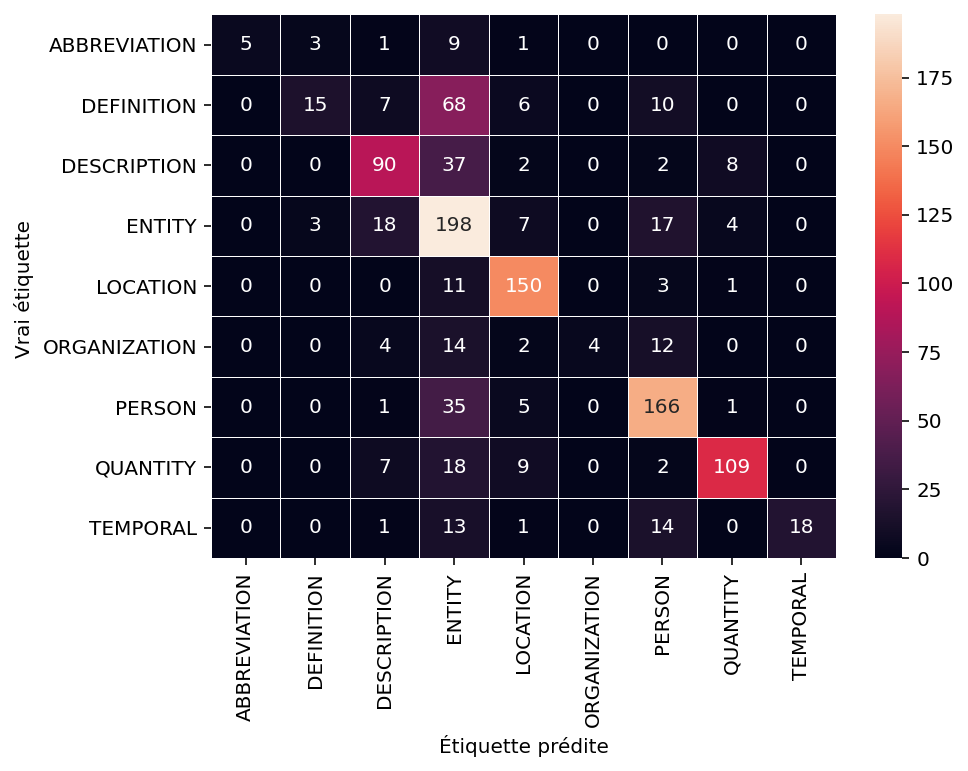

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format ='retina'

from sklearn.metrics import confusion_matrix

# Matrice de confusion
y_pred = nb_classifier.predict(X_test_vectorized)
cm = confusion_matrix(y_test, y_pred)
print("\nMatrice de confusion\n", cm)

# Affichage graphique plus informatif avec Seaborne
def display_confusion_matrix(confusion_matrix, classes):
    print("\n\nVersion graphique de la matrice de confusion") 
    df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes)
    f, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(df_cm, annot=True, fmt="d", linewidths=.5, ax=ax)
    plt.ylabel('Vrai étiquette ')
    plt.xlabel('Étiquette prédite')
    
classes = nb_classifier.classes_
display_confusion_matrix(cm, classes)

On peut faire une **recherche par grille (grid search)** pour déterminer les paramètres d'un modèle. Dans le cas de *Naive Bayes*, on pourrait vouloir choisir le meilleur paramètre de lissage *alpha*. On utilise les données d'entraînement pour faire cela. 

In [18]:
from sklearn.model_selection import GridSearchCV
parameters = {'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

grid_search = GridSearchCV(nb_classifier, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train_vectorized, y_train)
best_parameters = grid_search.best_estimator_.get_params()
print("\nParamètres sélectionnés par grid search: ", best_parameters)

hold_out_evaluation(grid_search, X_test_vectorized, y_test)


Paramètres sélectionnés par grid search:  {'alpha': 0.3, 'class_prior': None, 'fit_prior': True}

Évaluation sur les données de tests
   Accuracy =  0.7239208633093526
   Macro rappel (recall) =  0.6289102865911183
   Macro précision =  0.7664873282676337
   Micro rappel (recall) =  0.7239208633093526
   Micro précision =  0.7239208633093526


## Classificateur de type Régression logistique

On refait la même démarche avec un classificateur de type **Régression logistique**. De plus, on réutilise les données et le *vectorizer* de l'exemple précédent.

In [19]:
from sklearn.linear_model import LogisticRegression

logit_classifier = LogisticRegression(max_iter=200)
cross_validation(logit_classifier, X_train_vectorized, y_train)


Évaluation par validation croisée (en entraînement) : 
   Exactitude (accuracy) sur chaque partition [0.80989876 0.784027   0.81327334 0.79752531 0.79504505]
   Exactitude moyenne: 0.80 (+/- 0.02)


Évaluation de l'**exactitude du modèle** sur les **données de test**

In [20]:
logit_classifier.fit(X_train_vectorized, y_train)
hold_out_evaluation(logit_classifier, X_test_vectorized, y_test)


Évaluation sur les données de tests
   Accuracy =  0.7985611510791367
   Macro rappel (recall) =  0.7442850041924471
   Macro précision =  0.8471060690777283
   Micro rappel (recall) =  0.7985611510791367
   Micro précision =  0.7985611510791367


Voici les **poids du classificateur** pour les mêmes mots que ceux étudiés dans la partie *Naive Bayes*. Regarder l'importance relative de certains mots qui est grande pour certaines classes. Par exemple:
- *where* a un poids de 4.3 pour la classe *LOCATION* .
- *when* a un poids de 3.4 pour la classe *TEMPORAL* .
- *who* a un poids de 3.3 pour la classe *PERSON* .
- *company* a un poids de 3.5 pour la classe *ORGANIZATION* .

À noter également les poids plus faibles des mots du 3e groupe, des mots qui comportent moins de signification. Prenez quelques secondes pour comparer les probabilités et les poids des mots *is* et *the*. Ceci illustre bien la différentece entre les classificateurs *Naive Bayes* et Régression logistique. 

In [21]:
import pandas as pd

df = pd.DataFrame(vectorizer.get_feature_names(), columns =['Mots']) 
for i in range(len(logit_classifier.classes_)):
    df[logit_classifier.classes_[i]] = list(logit_classifier.coef_[i])
question_words = ['how', 'what', 'when', 'where', 'which', 'who', 'whom', 'whose', 'why']
qw_weigths = df[df['Mots'].isin(question_words)]
display(qw_weigths)

clue_words = ['person', 'king', 'president', 'author', 'company', 'university', 'waterfall', 'animal', 
                  'country', 'city', 'date', 'year', 'distance', 'far', 'long', 'height', 
                  'located', 'stand', 'mean']
w_weights = df[df['Mots'].isin(clue_words)]
display(w_weights)

other_words = ['the', 'is', 'are', 'for', 'the', 'each', 'some', 'did', 'to', 'that']
other_weights = df[df['Mots'].isin(other_words)]
display(other_weights)

,Mots,ABBREVIATION,DEFINITION,DESCRIPTION,ENTITY,LOCATION,ORGANIZATION,PERSON,QUANTITY,TEMPORAL
3346,how,-0.314030,-0.790669,3.017486,-0.830588,-1.351710,-0.541603,-1.411246,3.160691,-0.938331
7207,what,1.004201,0.755042,-0.499145,1.075786,-0.048507,0.042814,-0.590372,-0.349601,-1.390217
7212,when,0.262358,-0.832032,-0.225677,-0.718146,-0.411446,-0.429837,-0.740798,-0.392073,3.487651
7213,where,-0.161901,-1.184851,-0.413027,-0.796851,4.259302,-0.303083,-0.707391,0.203033,-0.895230
7214,which,-0.167652,-0.891786,-1.080989,1.557666,0.169357,0.900801,0.799633,-0.894406,-0.392624
7222,who,-0.265614,1.834724,-1.657779,-0.791689,-1.339297,1.105056,3.321715,-0.961005,-1.246112
7225,whom,-0.022306,0.096648,-0.265073,-0.587635,-0.141863,-0.228662,1.394980,-0.066910,-0.179179
7227,whose,-0.015334,-0.282284,-0.336394,-0.282823,-0.225357,-0.071012,1.639506,-0.172245,-0.254056
7228,why,-0.129732,0.140688,3.529738,-0.927057,-0.554661,-0.245687,-0.677514,-0.498085,-0.637689


,Mots,ABBREVIATION,DEFINITION,DESCRIPTION,ENTITY,LOCATION,ORGANIZATION,PERSON,QUANTITY,TEMPORAL
475,animal,-0.041738,-3.433939e-01,-0.483599,2.016229,-0.714678,-0.090895,-0.212419,-0.095767,-0.033740
655,author,-0.003314,-5.912513e-02,-0.064978,-0.269927,-0.070467,-0.035615,0.602690,-0.080134,-0.019130
1431,city,-0.192675,-6.771242e-01,-0.278212,-1.057683,3.180525,-0.381193,-0.300240,-0.095981,-0.197417
1571,company,0.165716,-6.773521e-01,-0.484023,-0.902916,-0.749195,3.589417,-0.363544,-0.569464,-0.008638
1733,country,-0.130235,-8.074020e-01,-0.593113,-1.197776,3.859664,0.251986,-0.783458,-0.346290,-0.253376
1885,date,-0.106370,-6.425500e-01,-0.161182,-0.633161,-0.320282,-0.084423,-0.378282,-0.374201,2.700450
2091,distance,-0.005664,-2.891583e-02,-0.012700,-0.106697,-0.023251,0.156404,-0.006641,0.030593,-0.003129
2565,far,-0.003769,-3.560586e-02,-1.034535,0.021658,-0.082043,-0.028677,-0.052136,1.229495,-0.014387
3201,height,-0.000002,-2.985212e-07,-0.000252,-0.000033,-0.000009,-0.000002,-0.000026,0.000333,-0.000009
3764,king,-0.080597,-2.005650e-01,-0.274866,-0.159259,-0.231006,-0.201971,0.869401,-0.098346,0.377208


,Mots,ABBREVIATION,DEFINITION,DESCRIPTION,ENTITY,LOCATION,ORGANIZATION,PERSON,QUANTITY,TEMPORAL
557,are,-0.556770,1.662834,0.382209,-0.160324,-0.047561,-0.125344,-1.199794,0.360712,-0.315962
2028,did,-0.403491,-0.906855,0.505604,0.371726,-0.362133,-0.056274,-0.464334,-0.328535,1.644293
2240,each,-0.022985,-0.032240,-0.167326,0.068915,-0.021948,-0.051169,-0.119094,0.518154,-0.172306
2744,for,1.018157,-1.674734,0.525775,0.261884,-0.521135,0.175372,-0.031350,0.694017,-0.447985
3565,is,1.125302,1.941528,-0.440009,-0.745443,-0.156895,-1.139491,-1.014730,0.615366,-0.185629
6176,some,-0.050970,-0.759259,0.178230,0.344805,0.635301,-0.213386,0.200729,-0.279217,-0.056232
6661,that,-0.262355,-0.857628,0.298860,0.948086,-0.049525,0.649915,-0.244898,-0.152982,-0.329473
6663,the,-0.257360,-0.639685,0.264413,-0.084826,0.214886,0.146200,-0.055673,0.335006,0.077039
6743,to,-0.299764,-0.840538,0.895295,0.358592,0.266787,-0.381913,0.320485,0.213405,-0.532348


In [93]:
X_test_vectorized = vectorizer.transform(X_test)
hold_out_evaluation(logit_classifier, X_test_vectorized, y_test)


Évaluation sur les données de tests
   Accuracy =  0.8201438848920863
   Macro rappel (recall) =  0.7809321509819199
   Macro précision =  0.8705466484103354
   Micro rappel (recall) =  0.8201438848920863
   Micro précision =  0.8201438848920863




Version graphique de la matrice de confusion


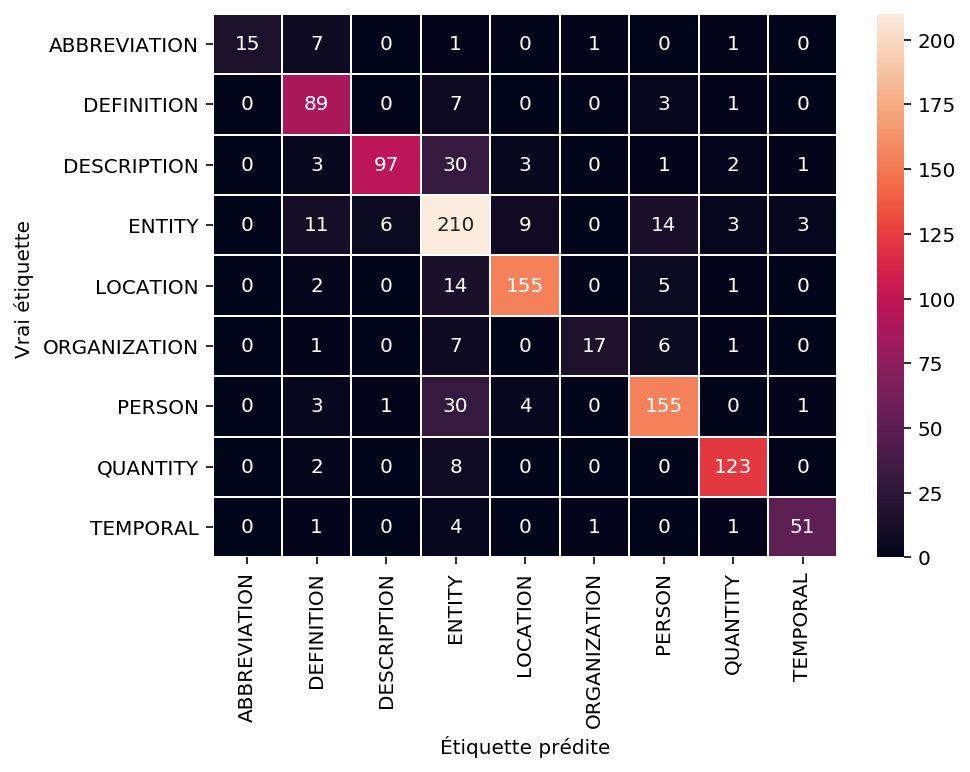

In [94]:
y_pred = logit_classifier.predict(X_test_vectorized)
cm = confusion_matrix(y_test, y_pred)
classes = logit_classifier.classes_
display_confusion_matrix(cm, classes)